In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../')

In [2]:
from Modules.scraping import *
from Modules.support_functions import *
from Modules.Growth_curve_fitting import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
dat = scrap_covid_data()

# START scraping
### Requesting url nr 1
### Requesting url nr 2
# END scraping


In [4]:
data = cut_down(dat)

In [5]:
def find_timepoint_zero(df):
    df["Timepoint"] = -1

    point_zero = df.loc[df['Infected']>0, "Date"][0]
    df.loc[df['Date'] == point_zero, "Timepoint"] = 0

    previous = -1
    for i, row in df.iterrows():
        if i == point_zero or previous != -1:
            previous = previous + 1
            df.at[i,'Timepoint'] = previous
            
    return df

In [6]:
# Get German data
DE = country_filter(data, Country='Germany')
DE = find_timepoint_zero(DE)
DE = DE[DE.Timepoint != -1]

### Plot growth rate of Covid 19 in Germany

Text(0,0.5,'New_Infections')

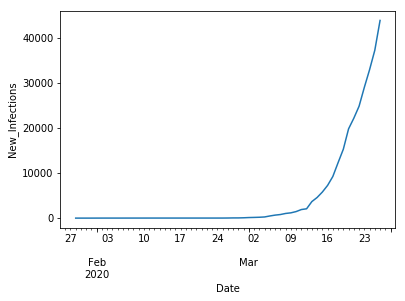

In [7]:
fig, ax = plt.subplots()
DE.loc[:,'Infected'].iloc[1:].plot()
ax.set_ylabel('New_Infections')

### Plot log of growth rate of Covid 19 in Germany

Text(0,0.5,'New_Infections')

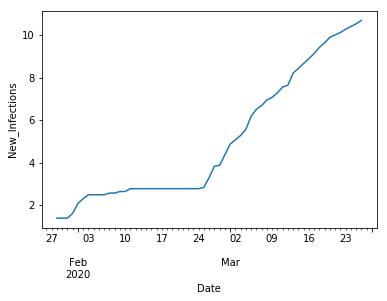

In [8]:
fig, ax = plt.subplots()
np.log(DE.loc[:,'Infected'].iloc[1:]).plot()
ax.set_ylabel('New_Infections')

### Analyse the stationarity of the time series 

In [9]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
print('AdFuller:',adfuller(np.log(DE.loc[:,'Infected']).diff()[1:])[1])
print('KPSS:',kpss(np.log(DE.loc[:,'Infected']).diff()[1:])[1])

AdFuller: 0.11526977639110586
KPSS: 0.1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Indicates AR 1 Process


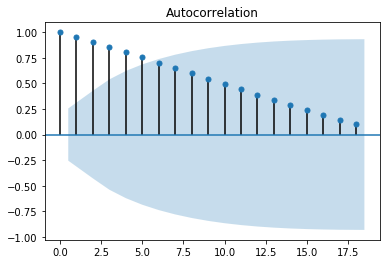

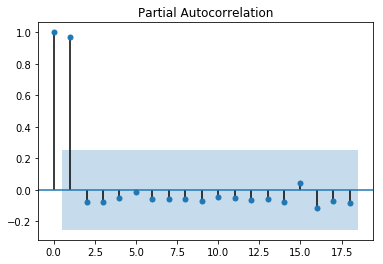

In [10]:
plot_acf(np.log(DE.loc[:,'Infected'])[1:])
plot_pacf(np.log(DE.loc[:,'Infected'])[1:])
print('Indicates AR 1 Process')

### Fit ARIMA model with Auto ARIMA 

In [11]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(np.log(DE.loc[:,'Infected'])[1:], start_p=0, start_q=0,
                           max_p=1, max_q=1, m=1,
                           start_P=0, seasonal=False,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Fit ARIMA: order=(0, 1, 0); AIC=-38.808, BIC=-34.687, Fit time=0.133 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-52.364, BIC=-46.182, Fit time=0.227 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-48.998, BIC=-42.817, Fit time=0.036 seconds
Fit ARIMA: order=(1, 1, 1); AIC=-53.237, BIC=-44.995, Fit time=0.098 seconds
Total fit time: 0.520 seconds
-53.23657235714418


### Forecasting 

In [12]:
train = pd.Series(np.log(DE.loc[:,'Infected'])[1:-3])
test = pd.Series(np.log(DE.loc[:,'Infected'])[-3:])
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=3)
#Back transformation
train, test, future_forecast = np.exp(train), np.exp(test) , np.exp(future_forecast)
print(future_forecast)

[33906.49723137 39571.16172955 46186.61529152]


In [13]:
future_forecast = pd.Series(future_forecast, index= test.index)
test_series = train.append(test)
forecast_series = train.append(future_forecast)

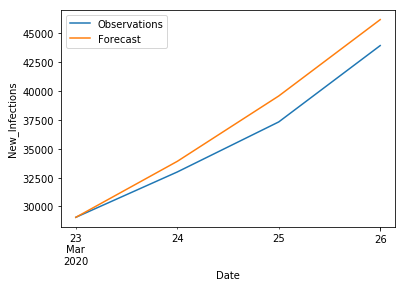

In [14]:
fig, ax = plt.subplots()
test_series.iloc[-4:].plot()
forecast_series.iloc[-4:].plot()
ax.set_ylabel('New_Infections')
ax.legend(['Observations', 'Forecast'])

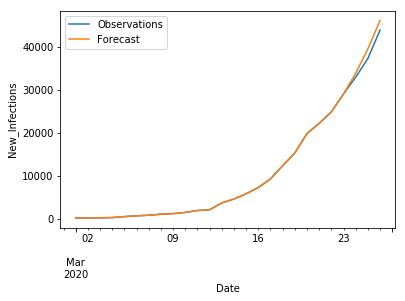

In [15]:
fig, ax = plt.subplots()
test_series.loc['2020-03-01':].plot()
forecast_series.loc['2020-03-01':].plot()
ax.set_ylabel('New_Infections')
ax.legend(['Observations', 'Forecast'])

# Model growth rate of Covid 19 in China 
## Fit polynom and extract parameters

In [17]:
#Get the Data 
CH = country_filter(data, Country='China')
state_list = CH['Province/State'].drop_duplicates()

### Example: Fit polynom to data in Zhejiang 

In [18]:
y = np.array(CH.loc[CH['Province/State']=='Zhejiang','Infected'].transform(lambda x: x*(100/x.max())))
x = np.array(range(0,len(y)),dtype=float)
#params,_ = fit(logistic,x,y)
params = np.polyfit(x,y, deg=3)
p = np.poly1d(params)
print(params)

[ 1.47095318e-03 -1.94489632e-01  8.27120914e+00 -1.46012433e+01]


Text(0,0.5,'Number of Infections in %')

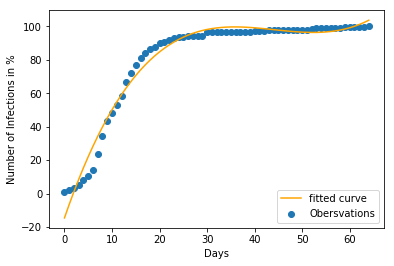

In [19]:
fig, axes = plt.subplots()
plt.scatter(x,y)
plt.plot(x,p(x),color='orange')
#plt.plot(x,logistic(x,params[0],params[1],params[2],params[3],params[4]),color='orange')
axes.legend(['fitted curve','Obersvations'])
axes.set_xlabel('Days')
axes.set_ylabel('Number of Infections in %')

### Fit the Richards model for each state & extract parameters

In [22]:
params = list()
missing_states = list()
for state in state_list:
    y = CH.loc[CH['Province/State']==state,'Infected'].transform(lambda x: x*(100/x.max()))
    x = np.array(range(0,len(y)),dtype=float)
    try:
        new_params = np.polyfit(x,y, deg=3)
        params.append(new_params)
    except:
        print('Couldnt fit:',state)
        missing_states.append(state)        
fit_state = state_list.loc[~np.isin(state_list,missing_states)]
target = pd.DataFrame(params, columns=['x3', 'x2', 'x1', 'c',], index = fit_state)    
        

In [41]:
print('Targets Index',len(target.index))
print('Features Index',len(feature_space.index))
target = target.drop(target.index[~np.isin(target.index,feature_space.index)].values)
feature_space = feature_space.drop('Passenger_National_Railroad',axis=1)

Targets Index 31
Features Index 31


### Read in features

In [130]:
import pandas as pd
import os 

os.chdir('/Users/matthiasboeker/Desktop/Covid_19_Forecast/Data')
data_files = []
for file in os.listdir():
    if file.endswith('.csv'):
        data_files.append(file)
        #data_list = data_list
    
features=[]
for i in range(0,len(data_files)):        
    data =pd.read_csv(data_files[i], sep=',', skiprows=3, encoding= 'unicode_escape')
    data.index = data.loc[:,'Region']
    data = data.loc[:,'2018']
    #data = data.iloc[:-2]
    data = data.rename(data_files[i][:-4])
    cut = 1
    if len(data)>32:
        cut = (len(data)-32)+1
    data= data.iloc[:-cut]
    features.append(data)
feature_space = pd.DataFrame(features).T

In [133]:
feature_space['Urban_Ratio'] = feature_space['Urban_Res']/feature_space['Rural_Res']
feature_space = feature_space.drop(['Urban_Res','Rural_Res'],axis=1)
feature_space['Students'] = feature_space['Students_high']+feature_space['Students_primary']+feature_space['Students_Secondary']
feature_space = feature_space.drop(['Students_high','Students_primary','Students_Secondary'],axis=1)
feature_space['Perc_Gen_Hospitals'] = feature_space['Number_general_hospitals']/feature_space['Number_health_inst']
feature_space = feature_space.drop(['Passenger_National_Railroad'],axis=1)

### Analyse the correlation of the feature space

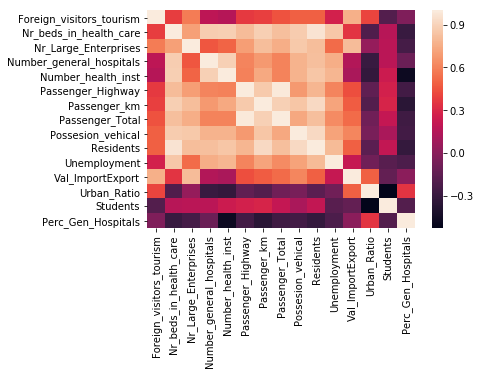

ValueError: Cannot index with multidimensional key

In [137]:
import seaborn as sn
corr = feature_space.corr()
sn.heatmap(corr, annot=False)

plt.show()

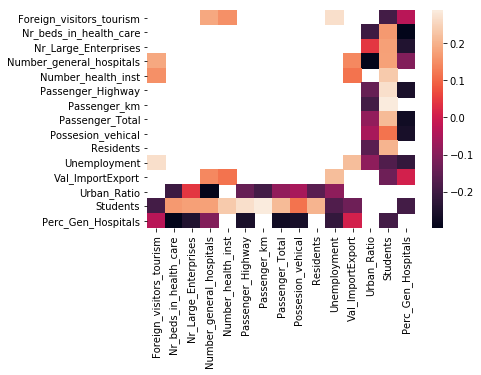

In [144]:
sn.heatmap(corr[0.3>np.abs(corr)], annot=False)
plt.show()


In [155]:
corr[0.2>np.abs(corr)]

,Foreign_visitors_tourism,Nr_beds_in_health_care,Nr_Large_Enterprises,Number_general_hospitals,Number_health_inst,Passenger_Highway,Passenger_km,Passenger_Total,Possesion_vehical,Residents,Unemployment,Val_ImportExport,Urban_Ratio,Students,Perc_Gen_Hospitals
Foreign_visitors_tourism,NaN,NaN,NaN,0.185695,0.155212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.192951,-0.029855
Nr_beds_in_health_care,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166190,NaN
Nr_Large_Enterprises,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042727,0.175637,NaN
Number_general_hospitals,0.185695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.143435,NaN,0.177349,-0.103780
Number_health_inst,0.155212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.115412,NaN,NaN,NaN
Passenger_Highway,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.143496,NaN,NaN
Passenger_km,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.193267,NaN,NaN
Passenger_Total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.083761,NaN,NaN
Possesion_vehical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.054119,0.116768,NaN
Residents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.161175,NaN,NaN


In [173]:
feature_space = feature_space.drop(['Number_general_hospitals','Number_health_inst','Nr_beds_in_health_care',
                                   'Nr_Large_Enterprises','Possesion_vehical',
                                   'Passenger_km','Passenger_Total','Passenger_Highway','Foreign_visitors_tourism',
                                   'Perc_Gen_Hospitals','Residents','Val_ImportExport','Students'],axis=1)

In [174]:
feature_space = feature_space.sort_index()
target = target.sort_index()

### Conducting PCA first to reduce the dimensionality 

In [175]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=3)
pca.fit(feature_space)
print('explained variance:',pca.explained_variance_ratio_)
transformed = pca.fit_transform(feature_space)

ValueError: n_components=3 must be between 0 and min(n_samples, n_features)=2 with svd_solver='full'

In [179]:
import statsmodels.api as sm


mod = sm.GLS(target['c'], feature_space)
res = mod.fit()
print(res.summary())

                                 GLS Regression Results                                
Dep. Variable:                      c   R-squared (uncentered):                   0.789
Model:                            GLS   Adj. R-squared (uncentered):              0.774
Method:                 Least Squares   F-statistic:                              54.07
Date:                Fri, 27 Mar 2020   Prob (F-statistic):                    1.65e-10
Time:                        15:24:01   Log-Likelihood:                         -104.36
No. Observations:                  31   AIC:                                      212.7
Df Residuals:                      29   BIC:                                      215.6
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [209]:
from datetime import date, timedelta
today = date.today()
start = today-timedelta(15)

### Get weather data

In [211]:
from weatherbit.api import Api
api_key = '90c0fe3847f2481a801b44297e55857b'
api = Api(api_key)
api.set_granularity('daily')
for state in state_list:
    lon = CH.loc[CH['Province/State']==state,'Long'][0]
    lat = CH.loc[CH['Province/State']==state,'Lat'][0]
    
    history = api.get_history(lat=lat,lon=lon, start_date= start.strftime("%Y-%m-%d"),end_date=today.strftime("%Y-%m-%d"))

HTTPError: 400 Client Error: Bad Request for url: https://api.weatherbit.io/v2.0/history/daily?key=90c0fe3847f2481a801b44297e55857b&lat=29.1832&lon=120.0934&start_date=2020-03-12&end_date=2020-03-27

In [185]:
CH.loc[CH['Province/State']=='Hubei','Long'][0]

112.2707

In [202]:
30*15


450

In [212]:
history